In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Load the dataset

data_frame = pd.read_csv('/content/Monkeypox_Dataset.csv')
# Initial Exploration
print(data_frame.info())
print(data_frame.describe())
print("Missing Values per Column:\n", data_frame.isnull().sum())

# Display the first few rows
print(data_frame.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Test ID                         25000 non-null  object 
 1   Systemic Illness                18784 non-null  object 
 2   Encoded Systemic Illness        24998 non-null  float64
 3   Rectal Pain                     24997 non-null  float64
 4   Sore Throat                     25000 non-null  int64  
 5   Penile Oedema                   24994 non-null  float64
 6   Oral Lesions                    24996 non-null  object 
 7   Solitary Lesion                 25000 non-null  int64  
 8   Swollen Tonsils                 24993 non-null  float64
 9   HIV Infection                   24995 non-null  float64
 10  Red blood cells count           25000 non-null  int64  
 11  White blood cells count         25000 non-null  int64  
 12  Home ownership                  

In [ ]:
# Changing the MPOX Value to binary
df = pd.DataFrame(data_frame)

# Function to convert 'MPOX PCR Result' to binary
def MPOX_Result_to_binary(value):
    if value == 'Positive':
        return 1
    else:
        return 0

# Apply the function to create the binary column
df['MPOX_Result'] = df['MPOX PCR Result'].apply(MPOX_Result_to_binary)

# Dropping unretained variables
columns_drop = ['Month of Birth', 'White blood cells count', 'Red blood cells count',
                'MPOX PCR Result', 'Home ownership', 'Systemic Illness', 'Test ID']
new_data_frame = df.drop(columns=columns_drop)

# Display the updated DataFrame
print(new_data_frame)


       Encoded Systemic Illness  Rectal Pain  Sore Throat  Penile Oedema  \
0                           0.0          0.0            1            1.0   
1                           1.0          1.0            0            1.0   
2                           1.0          0.0            1            1.0   
3                           0.0          1.0            0            0.0   
4                           3.0          1.0            1            1.0   
...                         ...          ...          ...            ...   
24995                       0.0          1.0            1            0.0   
24996                       1.0          0.0            1            1.0   
24997                       0.0          1.0            1            0.0   
24998                       3.0          0.0            1            0.0   
24999                       3.0          0.0            0            1.0   

      Oral Lesions  Solitary Lesion  Swollen Tonsils  HIV Infection Age  \
0           

In [ ]:
# Convert 'Age' to numeric and handle invalid entries
new_data_frame['Age'] = pd.to_numeric(new_data_frame['Age'], errors='coerce')
new_data_frame['Age'] = new_data_frame['Age'].astype('Int64')

# Replace '0' and negative ages with NaN
new_data_frame['Age'] = new_data_frame['Age'].replace({0: np.nan, -23: np.nan})

# Remove unrealistic values (e.g., Age > 120)
new_data_frame['Age'] = new_data_frame['Age'].where(new_data_frame['Age'] <= 120, np.nan)

# Fill NaN values in 'Age' with the median of valid ages
median_age = new_data_frame['Age'].median(skipna=True)
new_data_frame['Age'] = new_data_frame['Age'].fillna(median_age)

# Ensure 'Age' is a positive integer
new_data_frame['Age'] = new_data_frame['Age'].astype(int)

# Verify unique values in 'Age'
print(f"Cleaned Unique Age Values:\n{new_data_frame['Age'].unique()}")



Cleaned Unique Age Values:
[37 24 34 40 36 30 23 41 32 46 27 47 53 31 25 26 52 51 56 39 61 35 50 58
 33 28 45 42 59 38 57 54 55 43 60 44 48 49 29]


In [ ]:
# Fill missing values with mode for categorical and median for numerical
for col in columns_to_fill:
    if new_data_frame[col].dtype == 'object':  # Check if column is categorical
        mode_value = new_data_frame[col].mode()[0]
        new_data_frame[col] = new_data_frame[col].fillna(mode_value)
    else:  # For numerical columns
        median_value = new_data_frame[col].median()
        new_data_frame[col] = new_data_frame[col].fillna(median_value)

# Replace inconsistent values in 'Oral Lesions'
if set(new_data_frame['Oral Lesions'].unique()) <= {'YES', 'No', '1', '0'}:
    new_data_frame['Oral Lesions'] = new_data_frame['Oral Lesions'].replace({'YES': 1, 'No': 0})
    new_data_frame['Oral Lesions'] = new_data_frame['Oral Lesions'].astype(int)

# Final check of unique values
print("Unique values after cleaning:")
for column in new_data_frame.columns:
    print(f"{column}: {new_data_frame[column].unique()}")


Unique values after cleaning:
Encoded Systemic Illness: [0. 1. 3. 2.]
Rectal Pain: [0. 1.]
Sore Throat: [1 0]
Penile Oedema: [1. 0.]
Oral Lesions: [1 0]
Solitary Lesion: [0 1]
Swollen Tonsils: [1. 0.]
HIV Infection: [0. 1.]
Age: [37 24 34 40 36 30 23 41 32 46 27 47 53 31 25 26 52 51 56 39 61 35 50 58
 33 28 45 42 59 38 57 54 55 43 60 44 48 49 29]
Health Insurance: [0 1]
Sexually Transmitted Infection: [0. 1.]
MPOX_Result: [0 1]


<ipython-input-84-b7961a4613a7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='MPOX_Result', data=new_data_frame, palette='Set2')


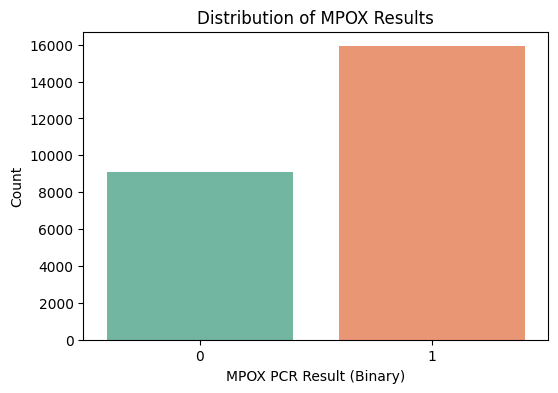

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='MPOX_Result', data=new_data_frame, palette='Set2')
plt.title('Distribution of MPOX Results')
plt.xlabel('MPOX PCR Result (Binary)')
plt.ylabel('Count')
plt.show()


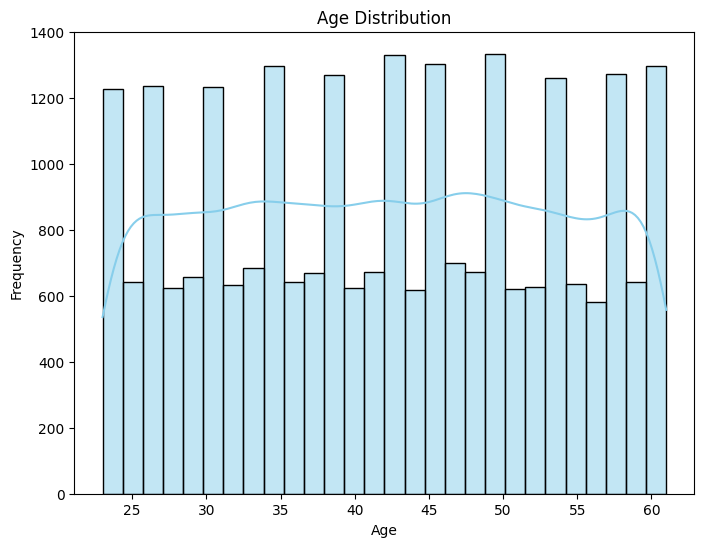

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(new_data_frame['Age'], kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


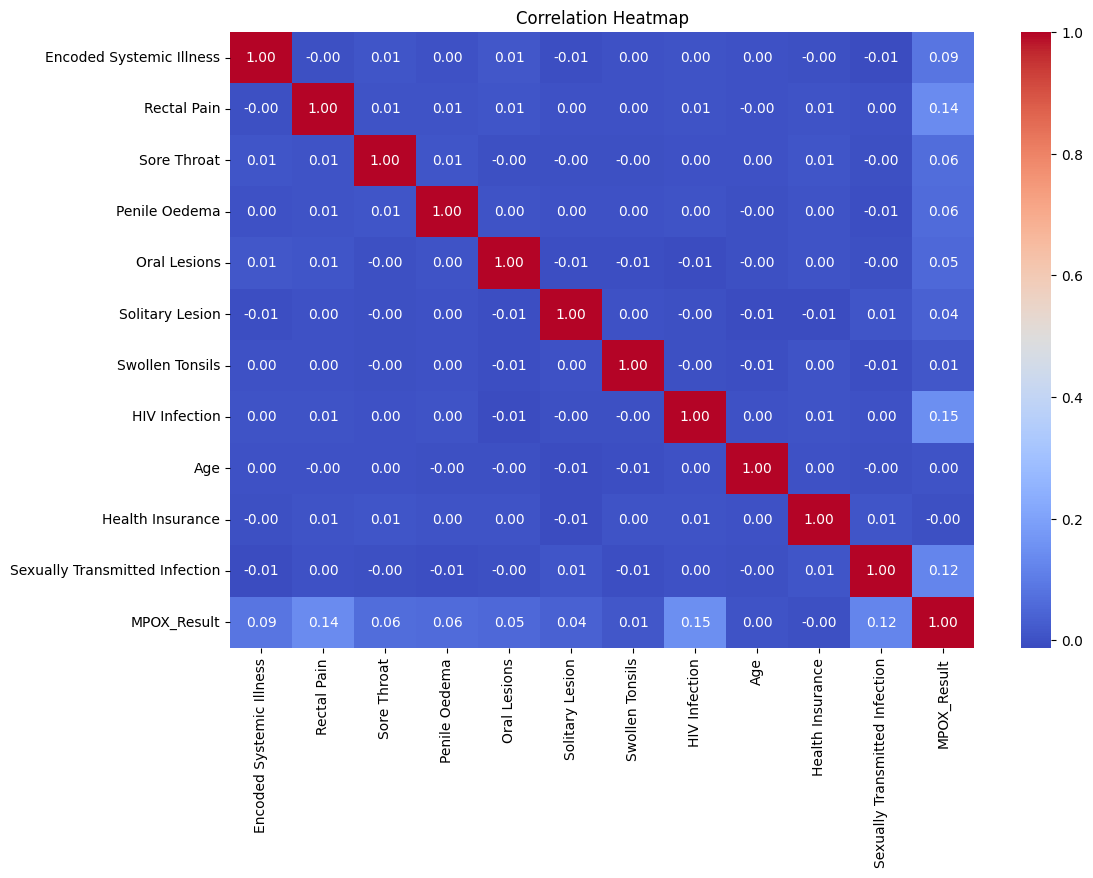

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(new_data_frame.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target variable
feature_cols = ['Encoded Systemic Illness','Rectal Pain','Sore Throat','Penile Oedema','Oral Lesions','Solitary Lesion','Swollen Tonsils','HIV Infection','Age','Health Insurance','Sexually Transmitted Infection']
X = new_data_frame[feature_cols]
y = new_data_frame['MPOX_Result']

# Scaling features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Logistic Regression Accuracy: 0.6814
              precision    recall  f1-score   support

           0       0.59      0.30      0.40      1754
           1       0.70      0.89      0.78      3246

    accuracy                           0.68      5000
   macro avg       0.65      0.59      0.59      5000
weighted avg       0.66      0.68      0.65      5000



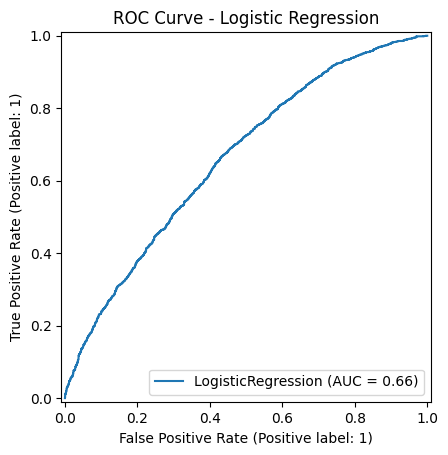

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

# Train Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predictions
y_pred_log = logreg.predict(X_test)

# Evaluate
log_accuracy = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression Accuracy: {log_accuracy}")
print(classification_report(y_test, y_pred_log))

# Plot ROC Curve
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title('ROC Curve - Logistic Regression')
plt.show()


Decision Tree Accuracy: 0.5846
              precision    recall  f1-score   support

           0       0.42      0.49      0.45      1754
           1       0.70      0.64      0.67      3246

    accuracy                           0.58      5000
   macro avg       0.56      0.56      0.56      5000
weighted avg       0.60      0.58      0.59      5000



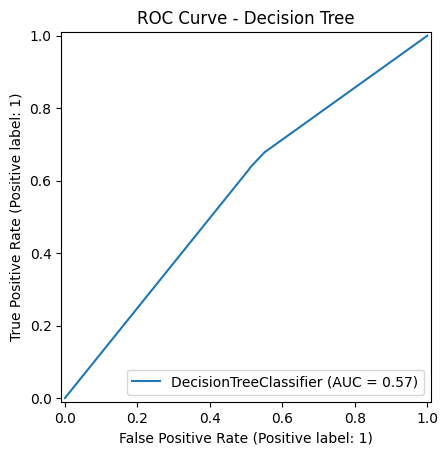

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)

# Predictions
y_pred_dtree = dtree.predict(X_test)

# Evaluate
dtree_accuracy = accuracy_score(y_test, y_pred_dtree)
print(f"Decision Tree Accuracy: {dtree_accuracy}")
print(classification_report(y_test, y_pred_dtree))

RocCurveDisplay.from_estimator(dtree, X_test, y_test)
plt.title('ROC Curve - Decision Tree')
plt.show()


Naïve Bayes Accuracy: 0.6822
              precision    recall  f1-score   support

           0       0.60      0.29      0.39      1754
           1       0.70      0.90      0.79      3246

    accuracy                           0.68      5000
   macro avg       0.65      0.59      0.59      5000
weighted avg       0.66      0.68      0.65      5000



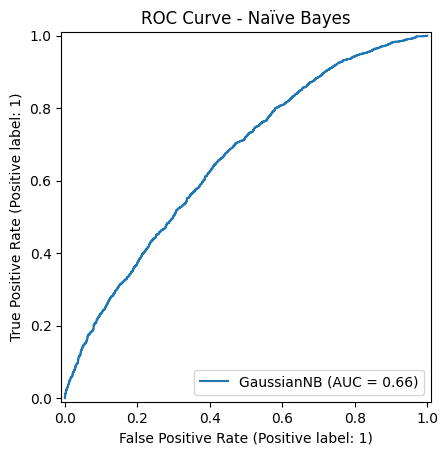

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train Naïve Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions
y_pred_gnb = gnb.predict(X_test)

# Evaluate
gnb_accuracy = accuracy_score(y_test, y_pred_gnb)
print(f"Naïve Bayes Accuracy: {gnb_accuracy}")
print(classification_report(y_test, y_pred_gnb))

RocCurveDisplay.from_estimator(gnb, X_test, y_test)
plt.title('ROC Curve - Naïve Bayes')
plt.show()


SVM Accuracy: 0.6792
              precision    recall  f1-score   support

           0       0.61      0.25      0.35      1754
           1       0.69      0.91      0.79      3246

    accuracy                           0.68      5000
   macro avg       0.65      0.58      0.57      5000
weighted avg       0.66      0.68      0.63      5000



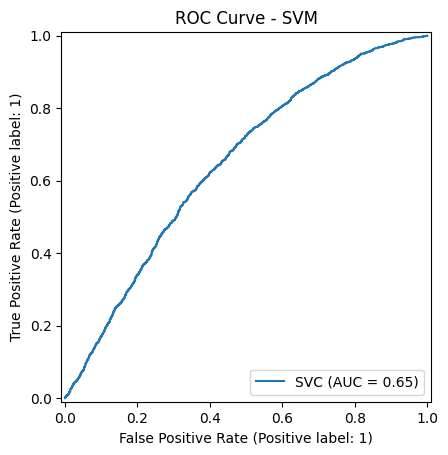

In [ ]:
from sklearn.svm import SVC

# Train SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predictions
y_pred_svm = svm.predict(X_test)

# Evaluate
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")
print(classification_report(y_test, y_pred_svm))

RocCurveDisplay.from_estimator(svm, X_test, y_test)
plt.title('ROC Curve - SVM')
plt.show()


KNN Accuracy: 0.6388
              precision    recall  f1-score   support

           0       0.48      0.39      0.43      1754
           1       0.70      0.77      0.74      3246

    accuracy                           0.64      5000
   macro avg       0.59      0.58      0.58      5000
weighted avg       0.62      0.64      0.63      5000



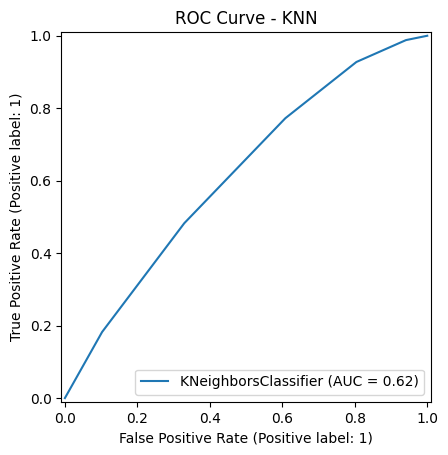

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predictions
y_pred_knn = knn.predict(X_test)

# Evaluate
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {knn_accuracy}")
print(classification_report(y_test, y_pred_knn))

RocCurveDisplay.from_estimator(knn, X_test, y_test)
plt.title('ROC Curve - KNN')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid Search for Naïve Bayes
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters for Naïve Bayes:", grid_search.best_params_)


Best Parameters for Naïve Bayes: {'var_smoothing': 1e-09}


Ensemble Accuracy: 0.5992

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.46      0.45      1754
           1       0.70      0.68      0.69      3246

    accuracy                           0.60      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.60      0.60      0.60      5000



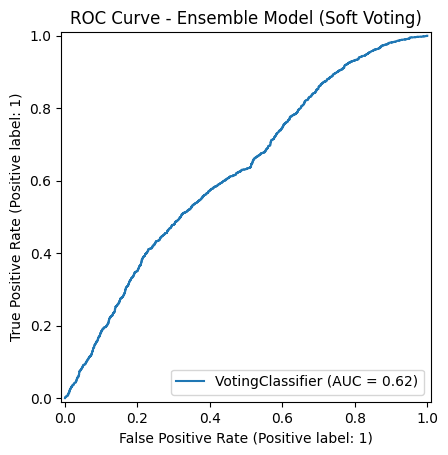

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, RocCurveDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define base learners with necessary configurations
dtree = DecisionTreeClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)  # Enable probability=True for SVM

# VotingClassifier with Soft Voting
ensemble = VotingClassifier(
    estimators=[('dt', dtree), ('svm', svm)],  # Combine Decision Tree and SVM
    voting='soft'  # Use soft voting to enable probability-based aggregation
)

# Fit the ensemble model using X_train and y_train
ensemble.fit(X_train, y_train)

# Predictions on X_test
ensemble_pred = ensemble.predict(X_test)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, ensemble_pred))

# Plot the ROC Curve
RocCurveDisplay.from_estimator(ensemble, X_test, y_test)
plt.title('ROC Curve - Ensemble Model (Soft Voting)')
plt.show()


Random Forest Accuracy: 0.6264
              precision    recall  f1-score   support

           0       0.47      0.44      0.45      1754
           1       0.71      0.73      0.72      3246

    accuracy                           0.63      5000
   macro avg       0.59      0.58      0.58      5000
weighted avg       0.62      0.63      0.62      5000



<ipython-input-99-fd50a0111423>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_cols, palette="viridis")


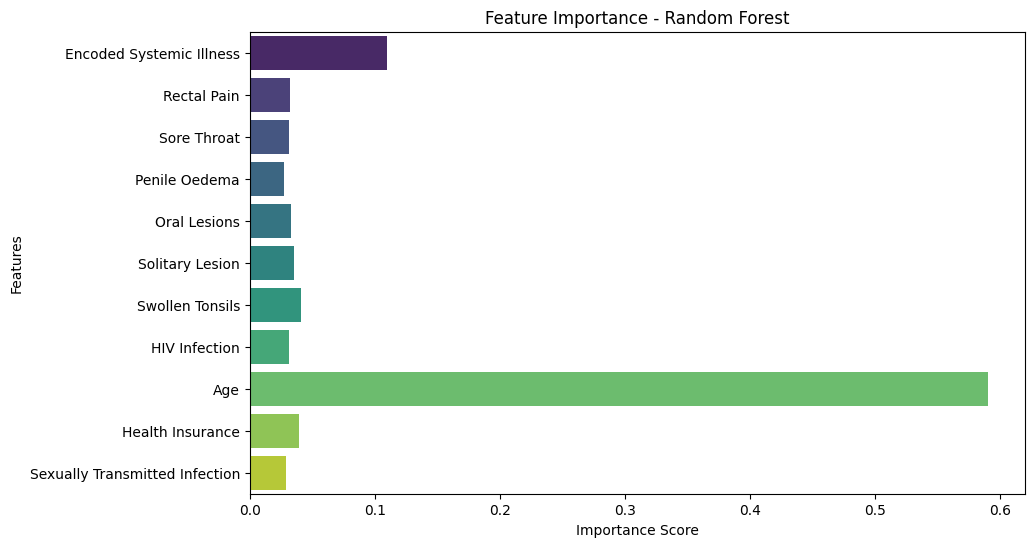

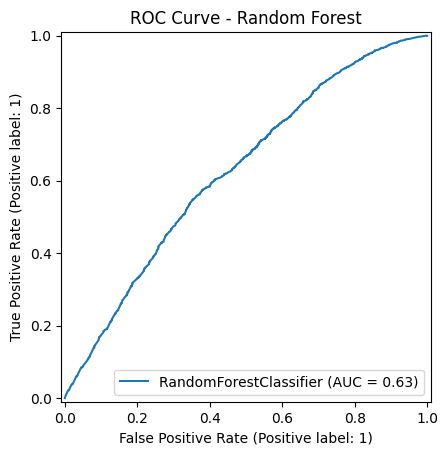

In [ ]:
#Bagging with Random forest
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predictions
y_pred_rf = random_forest.predict(X_test)

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")
print(classification_report(y_test, y_pred_rf))

# Feature Importance Plot
importances = random_forest.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_cols, palette="viridis")
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(random_forest, X_test, y_test)
plt.title('ROC Curve - Random Forest')
plt.show()


Gradient Boosting Accuracy: 0.7006
              precision    recall  f1-score   support

           0       0.62      0.38      0.47      1754
           1       0.72      0.87      0.79      3246

    accuracy                           0.70      5000
   macro avg       0.67      0.63      0.63      5000
weighted avg       0.69      0.70      0.68      5000



<ipython-input-100-e15e9f48716c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gb_importances, y=feature_cols, palette="coolwarm")


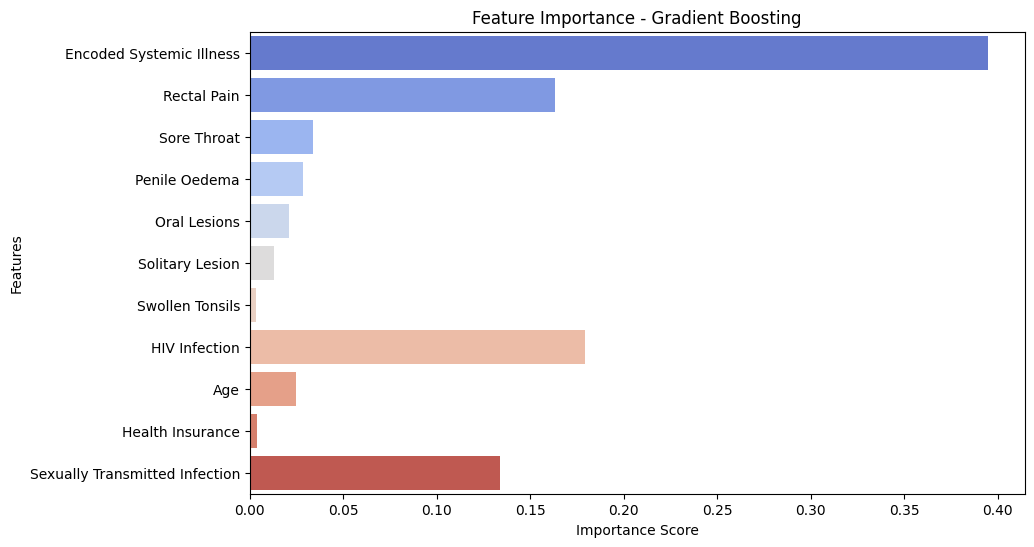

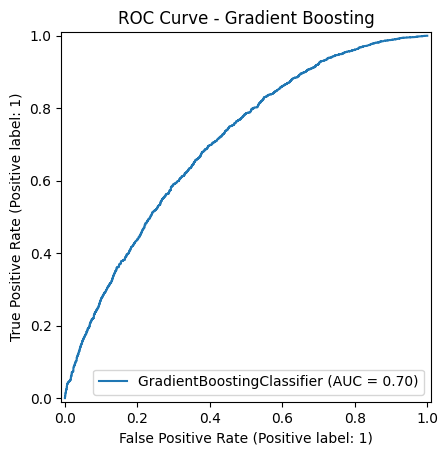

In [ ]:
# Boosting with Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)

# Predictions
y_pred_gbc = gbc.predict(X_test)

# Evaluate
gbc_accuracy = accuracy_score(y_test, y_pred_gbc)
print(f"Gradient Boosting Accuracy: {gbc_accuracy}")
print(classification_report(y_test, y_pred_gbc))

# Feature Importance
gb_importances = gbc.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=gb_importances, y=feature_cols, palette="coolwarm")
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(gbc, X_test, y_test)
plt.title('ROC Curve - Gradient Boosting')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.6956
              precision    recall  f1-score   support

           0       0.60      0.40      0.48      1754
           1       0.72      0.86      0.79      3246

    accuracy                           0.70      5000
   macro avg       0.66      0.63      0.63      5000
weighted avg       0.68      0.70      0.68      5000



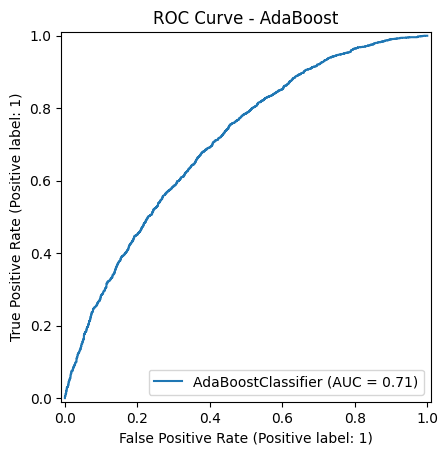

In [ ]:
#Adaptive Boosting (AdaBoost)
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost Classifier
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train, y_train)

# Predictions
y_pred_ab = adaboost.predict(X_test)

# Evaluate
ab_accuracy = accuracy_score(y_test, y_pred_ab)
print(f"AdaBoost Accuracy: {ab_accuracy}")
print(classification_report(y_test, y_pred_ab))

# ROC Curve
RocCurveDisplay.from_estimator(adaboost, X_test, y_test)
plt.title('ROC Curve - AdaBoost')
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:01:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6786
              precision    recall  f1-score   support

           0       0.56      0.38      0.46      1754
           1       0.72      0.84      0.77      3246

    accuracy                           0.68      5000
   macro avg       0.64      0.61      0.61      5000
weighted avg       0.66      0.68      0.66      5000



<ipython-input-102-9cbe780b445e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=xgb_importances, y=feature_cols, palette="magma")


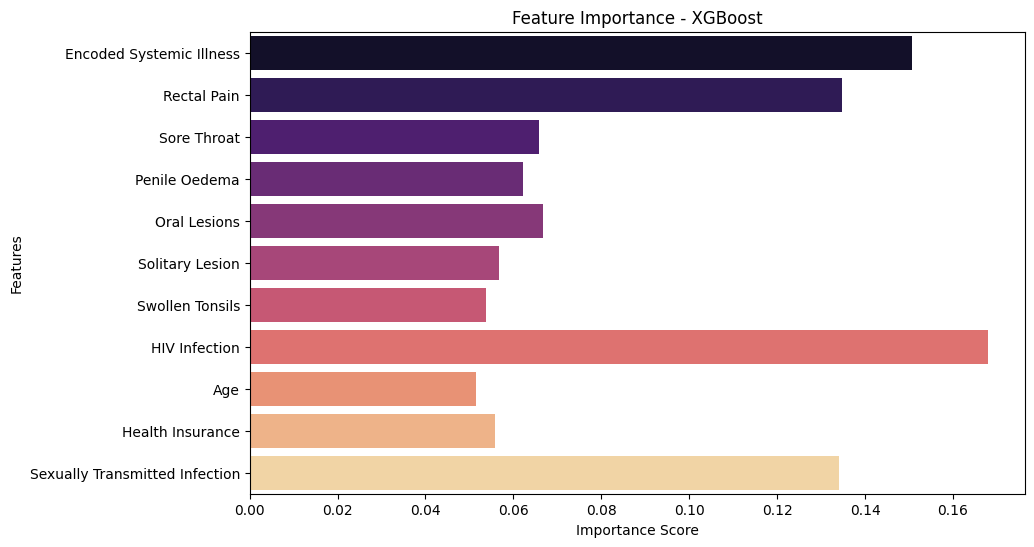

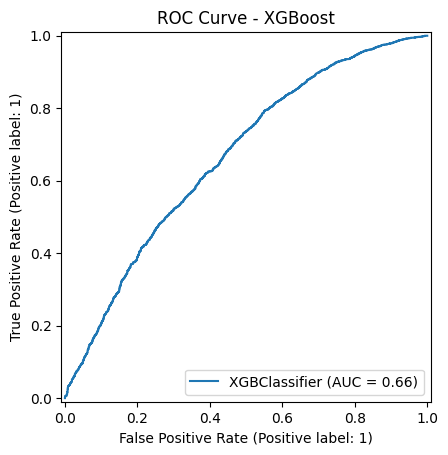

In [ ]:
#Extreme Gradient Boosting (XGBoost)
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy}")
print(classification_report(y_test, y_pred_xgb))

# Feature Importance
xgb_importances = xgb.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances, y=feature_cols, palette="magma")
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title('ROC Curve - XGBoost')
plt.show()


In [ ]:
#Hyperparameter Tuning with Grid Search for Boosting
from sklearn.model_selection import GridSearchCV

# Grid Search for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='accuracy')
grid_search_gb.fit(X_train, y_train)

# Best Parameters and Evaluation
print("Best Parameters for Gradient Boosting:", grid_search_gb.best_params_)
best_gbc = grid_search_gb.best_estimator_
best_gbc_accuracy = accuracy_score(y_test, best_gbc.predict(X_test))
print(f"Best Gradient Boosting Accuracy: {best_gbc_accuracy}")


Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
Best Gradient Boosting Accuracy: 0.7004


In [ ]:
#Tabular Summary of Results
import pandas as pd

# Collecting results in a DataFrame
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Naïve Bayes', 'SVM', 'KNN',
              'Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost'],
    'Accuracy': [log_accuracy, dtree_accuracy, gnb_accuracy, svm_accuracy, knn_accuracy,
                 rf_accuracy, gbc_accuracy, ab_accuracy, xgb_accuracy]
})

print(results.sort_values(by='Accuracy', ascending=False))


                 Model  Accuracy
6    Gradient Boosting    0.7006
7             AdaBoost    0.6956
2          Naïve Bayes    0.6822
0  Logistic Regression    0.6814
3                  SVM    0.6792
8              XGBoost    0.6786
4                  KNN    0.6388
5        Random Forest    0.6264
1        Decision Tree    0.5846


<ipython-input-106-556282d7efea>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results, palette='coolwarm')


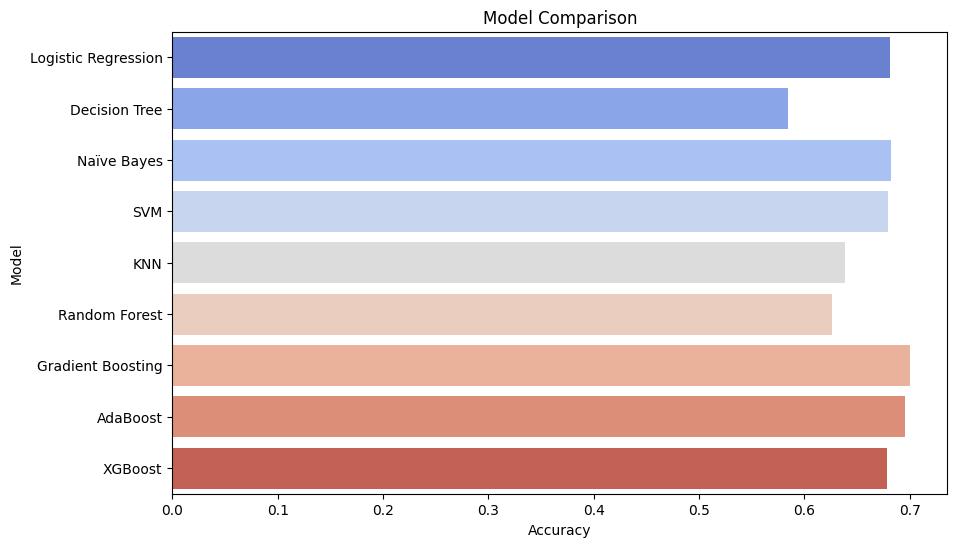

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results, palette='coolwarm')
plt.title('Model Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)

# Perform 10-fold cross-validation on the scaled features and target
cross_val_scores = cross_val_score(gbc, X_scaled, y, cv=10, scoring='accuracy')

# Print the results
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean CV Accuracy: {np.mean(cross_val_scores):.4f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cross_val_scores):.4f}")


Cross-Validation Scores: [0.6868 0.6796 0.6872 0.6944 0.704  0.6816 0.6884 0.688  0.7036 0.6964]
Mean CV Accuracy: 0.6910
Standard Deviation of CV Accuracy: 0.0080


SHAP values shape: (5000, 11)


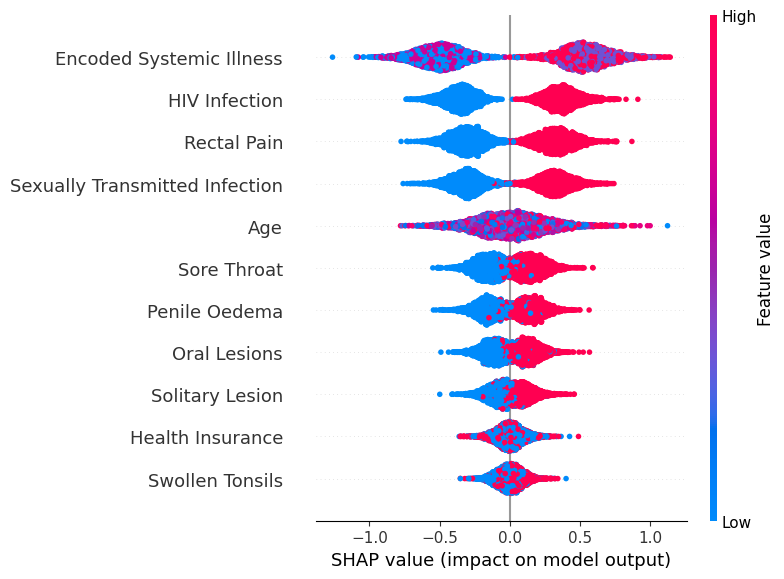

In [ ]:
import shap

# Initialize SHAP Tree Explainer
explainer = shap.TreeExplainer(xgb)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Verify shapes
print("SHAP values shape:", shap_values.shape)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_cols)

# Force Plot for a Single Prediction
shap.force_plot(
    explainer.expected_value,
    shap_values[0],  # SHAP values for the first sample
    feature_names=feature_cols
)


In [ ]:
# Simulate unseen data
unseen_data = X_test[:10]  # Example: Take the first 10 samples of the test set

# Predict using the best model
unseen_predictions = xgb.predict(unseen_data)

print("Predictions for Unseen Data:", unseen_predictions)


Predictions for Unseen Data: [1 1 0 1 1 1 1 1 1 1]


In [ ]:
!pip install scikit-optimize

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


from skopt import BayesSearchCV

# Define the parameter space for XGBoost
param_space = {
    'n_estimators': (50, 300),
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 10),
    'colsample_bytree': (0.3, 1.0),
}

# Create the Bayesian search object
bayes_search = BayesSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_space, cv=5, n_iter=30, random_state=42)

# Fit the Bayesian search
bayes_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)


Best Parameters: OrderedDict([('colsample_bytree', 0.3), ('learning_rate', 0.2), ('max_depth', 3), ('n_estimators', 50)])
Best Cross-Validation Score: 0.68885


In [ ]:
from sklearn.utils import resample

# Bootstrap resampling for confidence intervals
bootstrap_accuracies = []
for i in range(1000):
    X1_resampled, y_resampled = resample(X_test, y_test, replace=True, random_state=i)
    y_pred_resampled = xgb.predict(X1_resampled)
    bootstrap_accuracies.append(accuracy_score(y_resampled, y_pred_resampled))

# Calculate confidence interval
ci_lower = np.percentile(bootstrap_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_accuracies, 97.5)
print(f"95% Confidence Interval for XGBoost Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")


95% Confidence Interval for XGBoost Accuracy: [0.6650, 0.6912]


In [ ]:
def predict_mpox(features):
    # Ensure features are in the correct format
    scaled_features = scaler.transform([features])
    prediction = xgb.predict(scaled_features)
    return "Positive" if prediction == 1 else "Negative"

# Test with a sample feature vector
sample_features = X_test[0]
print("Predicted MPOX Result:", predict_mpox(sample_features))


Predicted MPOX Result: Positive


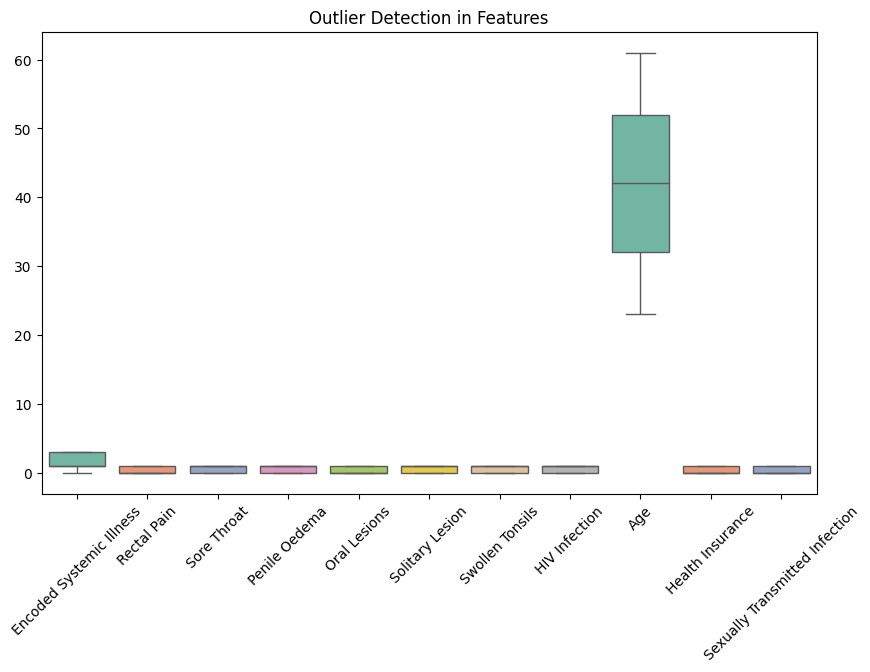

In [ ]:
# Outlier Detection
# Boxplot for Outlier Detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=X, palette="Set2")
plt.xticks(rotation=45)
plt.title("Outlier Detection in Features")
plt.show()

# Remove Outliers (Using IQR)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
X_cleaned = X[~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)]
y_cleaned = y.loc[X_cleaned.index]


In [ ]:
# Stacking Classifier
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[('dt', DecisionTreeClassifier()), ('knn', KNeighborsClassifier())],
    final_estimator=LogisticRegression()
)

stacking_model.fit(X_train, y_train)
stacking_accuracy = stacking_model.score(X_test, y_test)
print(f"Stacking Model Accuracy: {stacking_accuracy}")


Stacking Model Accuracy: 0.6684


In [ ]:
#Bagging Classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the BaggingClassifier with the updated parameter name
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)

# Fit the model
bagging_model.fit(X_train, y_train)

# Evaluate the model
bagging_accuracy = bagging_model.score(X_test, y_test)
print(f"Bagging Classifier Accuracy: {bagging_accuracy}")


Bagging Classifier Accuracy: 0.6306


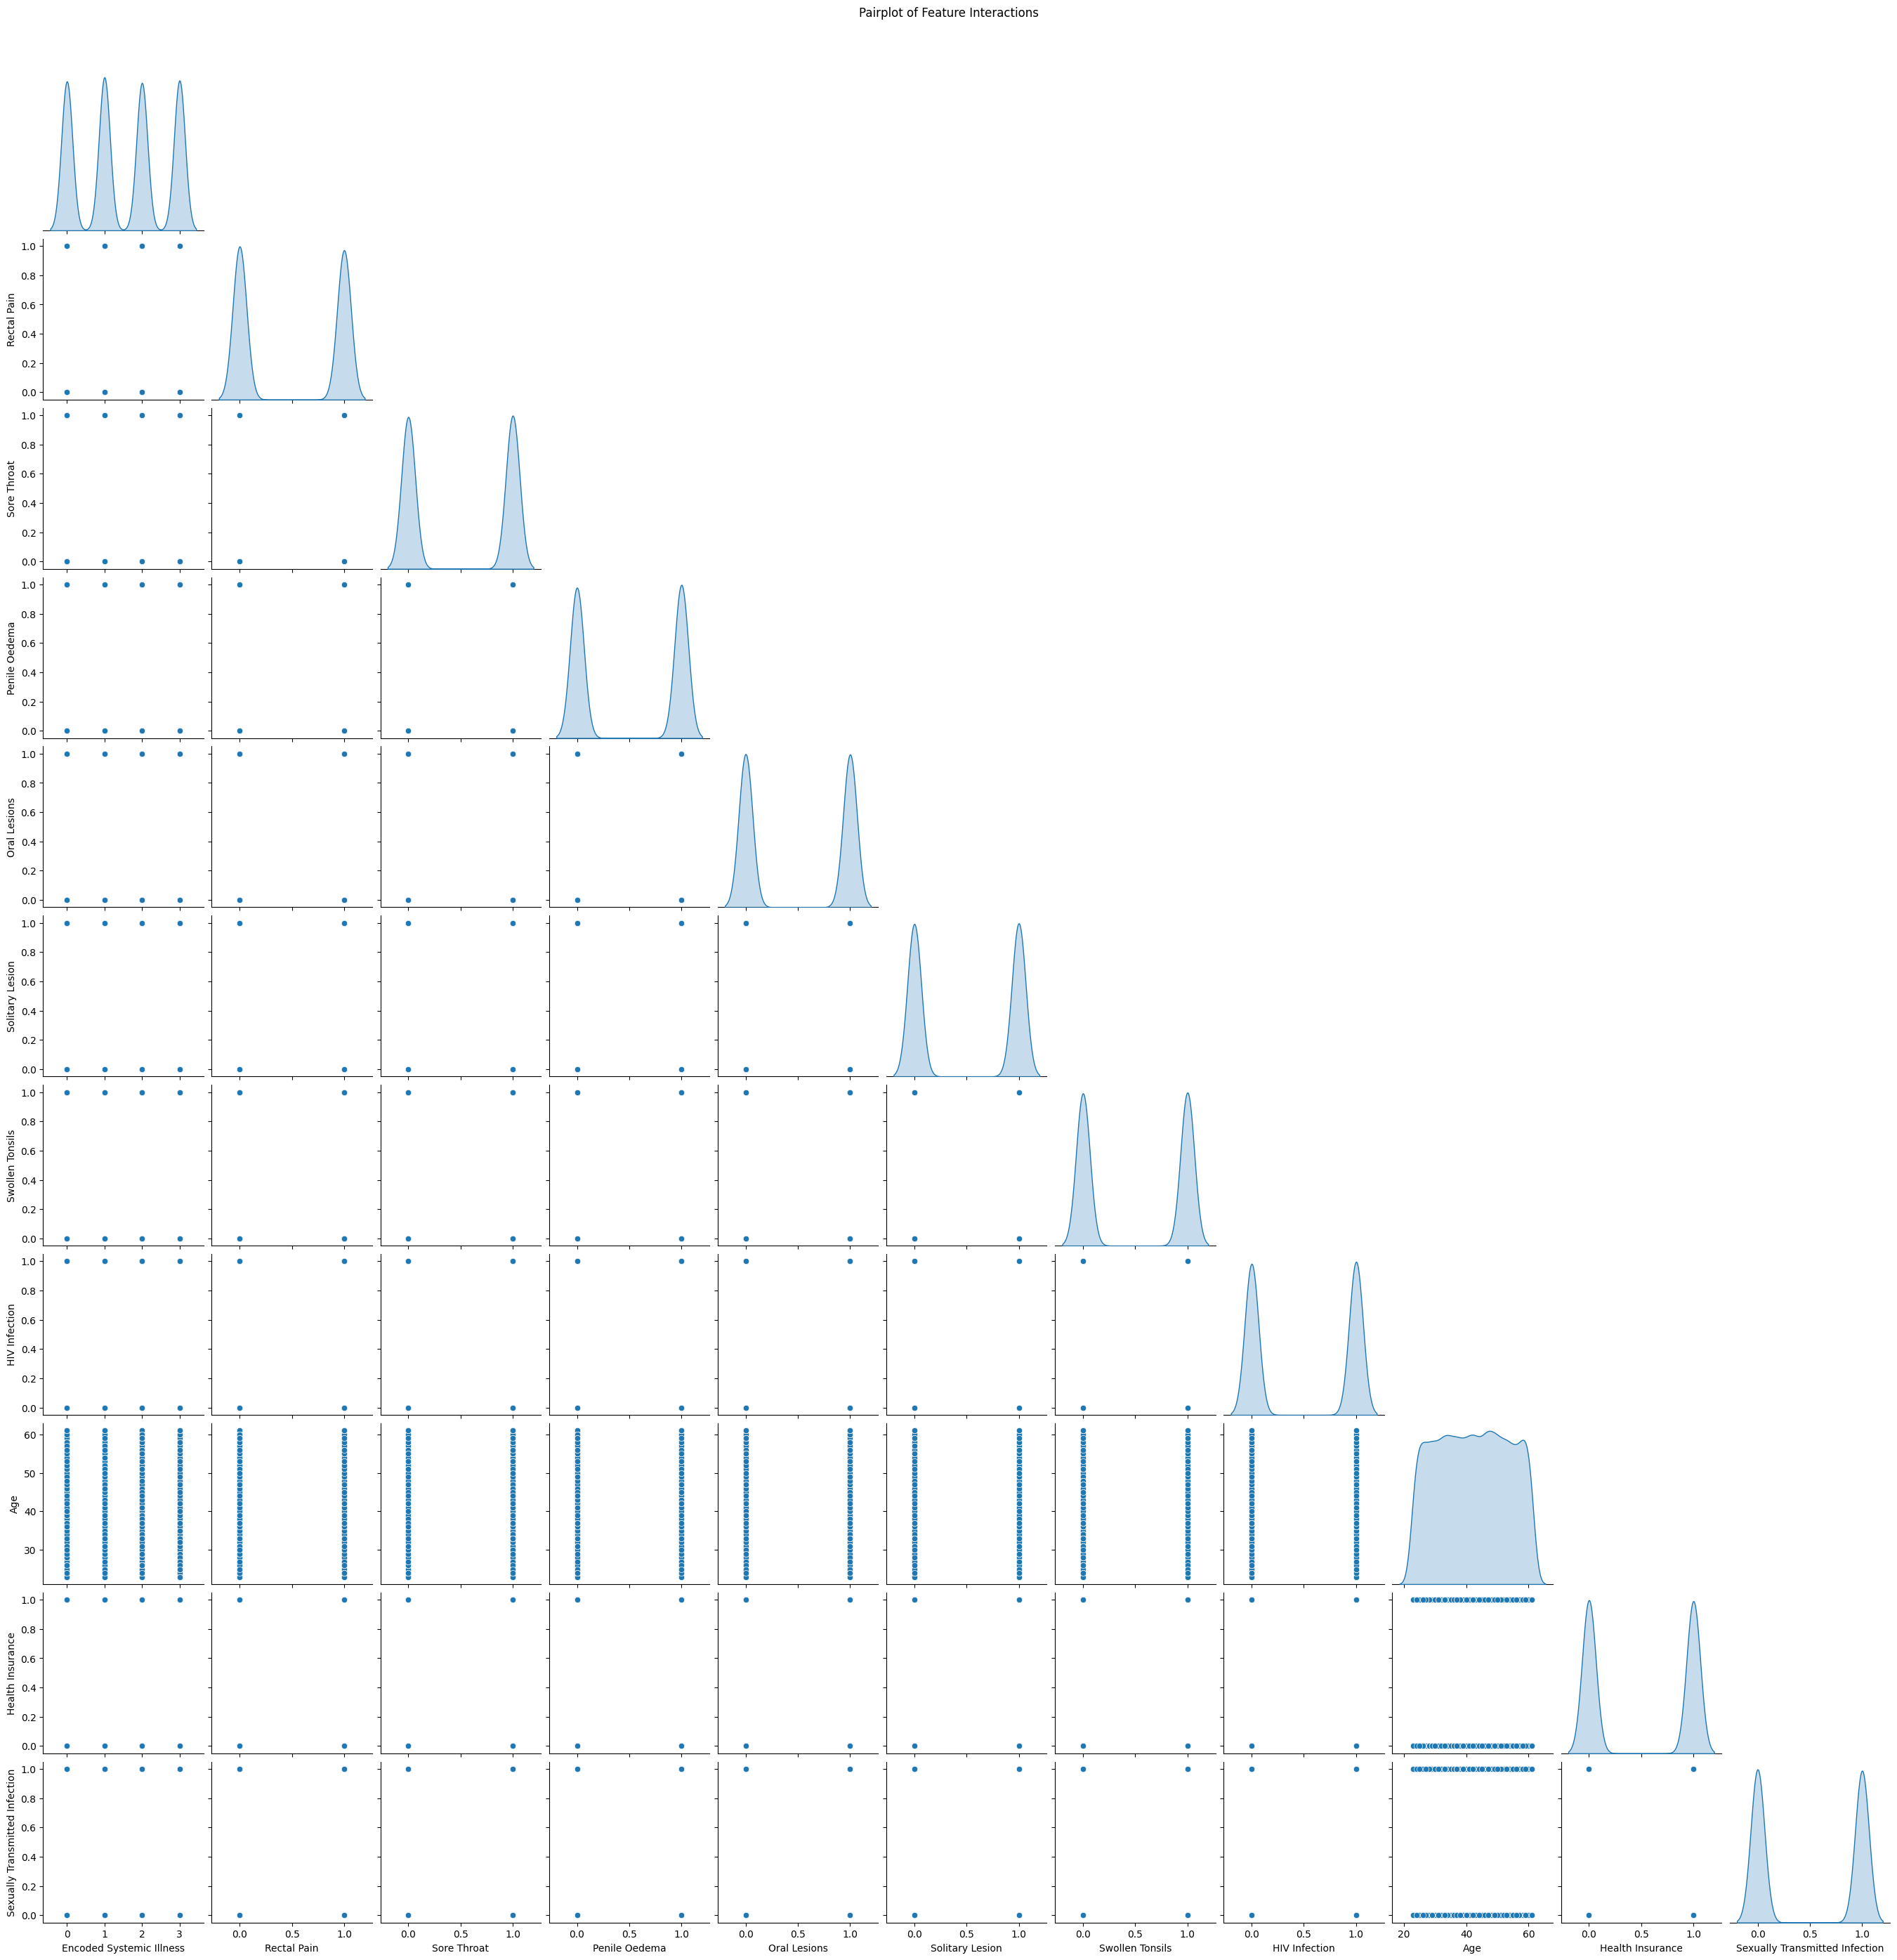

In [ ]:
#Feature Interactions visualization using pair plots
sns.pairplot(pd.DataFrame(X, columns=feature_cols), diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Feature Interactions', y=1.02)
plt.show()


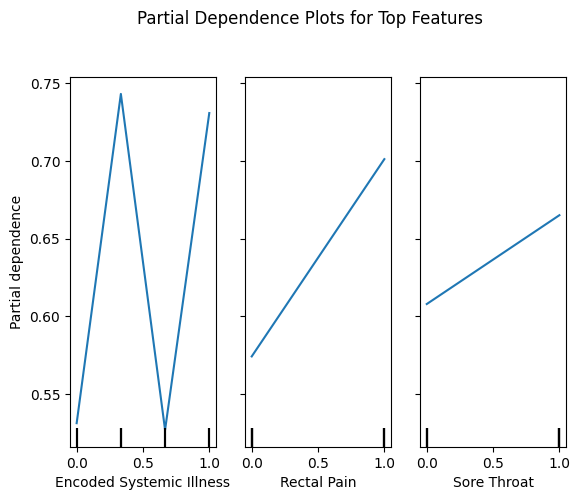

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# Ensure you are using a compatible scikit-learn version (>=1.0)
# Plot Partial Dependence for the top features
PartialDependenceDisplay.from_estimator(
    xgb,  # Replace 'xgb' with your trained XGBoost model
    X_test,  # Feature dataset
    features=[0, 1, 2],  # Indices of the features to analyze
    feature_names=feature_cols,  # Names of features
)
plt.suptitle("Partial Dependence Plots for Top Features", y=1.02)
plt.show()


# New Section